In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

The Bayesian Entropy method worked very well for value constraints. 
Using MDMM we are able to optimize for the lagrange multipliers and the value constraints. 
However, I am somehow not able to get a neural network to respect derivative constraints on the output y wrt x for a 1D-regression problem. This is easier in the case of a standard Gaussian Process, where we can use an analytical equation for the gradient of the covariance to enforce the derivative constraints.

In [2]:
# create directory for tensorboard logs
import os
if not os.path.exists('regression_benn_mdmm_deriv_constraint'):
    os.makedirs('regression_benn_mdmm_deriv_constraint')
    


In [3]:
# Bayesian Entropy Neural Network
# Define NN model
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.posterior_rho_init = -3.0
        self.prior_sigma_1 = 40.0
        self.prior_sigma_2 = 50.0
        self.blinear1 = BayesianLinear(input_dim, 4096, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),torch.tensor(3.0).to(device = torch.device('cuda:0'))))
        self.blinear2 = BayesianLinear(4096, output_dim, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),torch.tensor(3.0).to(device = torch.device('cuda:0'))))

    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.tanh(x_)
        x_ = self.blinear2(x_)
        return x_



In [4]:
sig_e = 0.1
nobs = 36
x = 10*np.random.rand(nobs)
ndim = 1
nd = (ndim+1)*(ndim+2)//2
from quad_basis import quad_basis
X = quad_basis(x)
e = sig_e*np.random.randn(nobs, 1)
beta_true = np.array([1,-2,1]).transpose().reshape(-1,1)
y = X@beta_true + e
# shift function by 5 to the right
X_train = x.reshape(-1,1)
y_train = y



In [5]:
def value_constraints(data):
    X_test = np.array([vc[0] for vc in data]).reshape(-1, 1)
    y_test = np.array([vc[1] for vc in data]).reshape(-1, 1)
    return np.concatenate((X_test, y_test), axis=0)

X_test, y_test = value_constraints([[40, 33]])


In [6]:
# Create dataloader for regression task
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1000, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1000, shuffle=True)

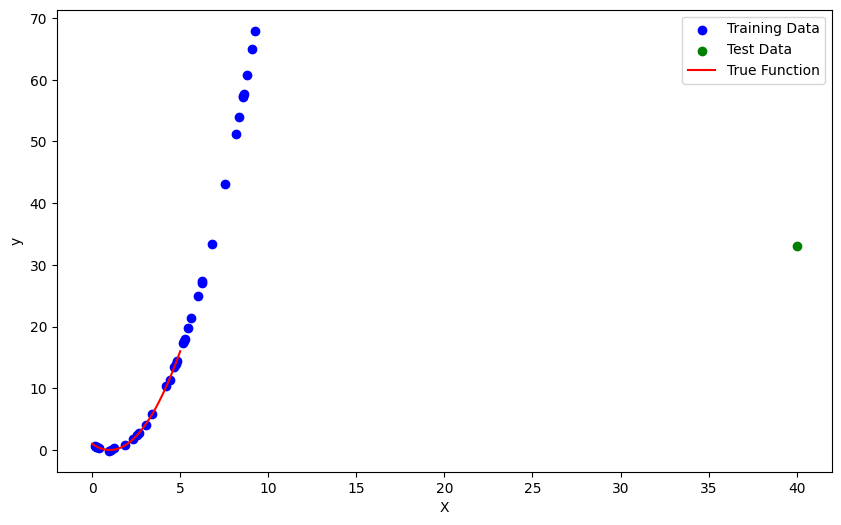

In [7]:
# Plot the training data and the true function 
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.scatter(X_test, y_test, color='green', label='Test Data')
# plot the true function 
x_plot = np.linspace(0, 5, 100)
y_plot = quad_basis(x_plot)@beta_true
plt.plot(x_plot, y_plot, color='red', label='True Function')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(1, 1).to(device)

optimizer_benn = optim.Adam(regressor.parameters(), lr=0.001)
# stepLR scheduler
scheduler_benn = optim.lr_scheduler.StepLR(optimizer_benn, step_size=200, gamma=0.25)
criterion = torch.nn.MSELoss()

regressor_benn = BayesianRegressor(1, 1).to(device)
criterion_benn = torch.nn.MSELoss()

# initial guess for eta
eta = torch.tensor(1., requires_grad=True)

# optimizer and scheduler for eta - SGD w/ one cycle lr
optimizer_eta = optim.SGD([eta], lr=1e-5, momentum=0.9) # eta is a list of tensors
scheduler_eta = optim.lr_scheduler.StepLR(optimizer_eta, step_size=100, gamma=0.5)

In [9]:
# function to print the chain of the computation graph
def graph(x):
    # x is a tensor
    print(x.grad_fn)

In [10]:
# mdmm constraint impl
def derivative_fn():
    '''
    Derivative function:
    Given a regressor that outputs a pred of shape [1,1], we need to compute the gradient of pred wrt x_c, where x_c 
    is the constraint point. The objective would be to enforce the derivative of the function at x_c to be -5.0.
    I am hoping that the slope gets affected around the neighborhood of x_c.
    '''
    x_c = torch.tensor([40.0]).to(device)
    x_c.requires_grad_()
    predictions = regressor_benn(x_c.reshape(-1,1).to(device))
    # do a backward pass to get the derivative of predictions at x_c
    predictions.backward(retain_graph=True)
    grad = x_c.grad.clone()
    x_c.grad.zero_()
    return grad.item().squeeze()

def derivative_fn_empirical():
    '''
    Derivative is computed around a neighborhood of x_c. 
    '''
    eps = 1.0
    # xs is a list of constraint points centered at x_c with a small epsilon
    x_c = torch.tensor([-5.0]).to(device)
    xs = [x_c - eps, x_c, x_c + eps]
    y = regressor_benn(torch.tensor(xs).reshape(-1,1).to(device))
    # compute the derivative using finite differences
    dy = (y[2] - y[0])/(xs[2] - xs[0])
    return dy.item()


derivative_constraint = mdmm.EqConstraint(derivative_fn_empirical, torch.tensor(-10.0).to(device))
mdmm_module = mdmm.MDMM([derivative_constraint])
opt = mdmm_module.make_optimizer(regressor_benn.parameters(), lr = 2e-3)


In [11]:
iteration = 0
best_loss = 1e6

N = 3
eps = 0.5
m = 10
regressor_benn.train()

eta_history = []
loss_history = []
loss_data_history = []
loss_constraint_history = []

best_loss = 1e9
# create summary writer based on datetime
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

writer = SummaryWriter('regression_benn_mdmm_deriv_constraint/' + current_time)

data_loss_weight = 1.0
time_elapsed_ = []
for epoch in range(2500):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer_benn.zero_grad()
        optimizer_eta.zero_grad()
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        loss_data = regressor_benn.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion_benn,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
        loss_data = 0.0*loss_data
        mdmm_return = mdmm_module(loss_data)
        opt.zero_grad()
        mdmm_return.value.backward()
        opt.step()
        # check if the loss is lower than the best_loss
        if mdmm_return.value.item() < best_loss:
            best_loss = loss_data
            best_model = regressor_benn
        
        # save history
        loss_data_history.append(loss_data.item())
        # print('Time elapsed for one iteration: {:.4f}'.format(end_time - start_time))
        if iteration%10==0:
            print("Loss: {:.4f} Loss_data: {:.4f} Constraint_Fn_Value: {:.4f} Infeasibility: {:.4f}".format(mdmm_return.value.item(), 
                                                                                                            loss_data.item(), mdmm_return.fn_values[0], 
                                                                                                            mdmm_return.infs[0].item()))
            print('-----------------------------')
            writer.add_scalar('Loss/loss_data', loss_data.item(), iteration)
            writer.add_scalar('Loss/total_loss', mdmm_return.value.item(), iteration)
            writer.add_scalar('Loss/constraint_fn_value', mdmm_return.fn_values[0], iteration) # TODO: assuming one constraint. What if there are multiple constraints?
            writer.add_scalar('Constraint Infeasibility', mdmm_return.infs[0].item(), iteration)
            writer.add_scalar('Lagrange Multiplier', mdmm_module[0].lmbda.item(), iteration)
            writer.flush()
        iteration += 1

/home/paralab/.local/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss: 55.7986 Loss_data: 0.0000 Constraint_Fn_Value: 0.5640 Infeasibility: -10.5640
-----------------------------
Loss: 56.1200 Loss_data: 0.0000 Constraint_Fn_Value: 0.5744 Infeasibility: -10.5744
-----------------------------
Loss: 56.2716 Loss_data: 0.0000 Constraint_Fn_Value: 0.5687 Infeasibility: -10.5687
-----------------------------
Loss: 56.4540 Loss_data: 0.0000 Constraint_Fn_Value: 0.5660 Infeasibility: -10.5660
-----------------------------
Loss: 56.6554 Loss_data: 0.0000 Constraint_Fn_Value: 0.5651 Infeasibility: -10.5651
-----------------------------
Loss: 56.7650 Loss_data: 0.0000 Constraint_Fn_Value: 0.5555 Infeasibility: -10.5555
-----------------------------
Loss: 57.0627 Loss_data: 0.0000 Constraint_Fn_Value: 0.5636 Infeasibility: -10.5636
-----------------------------
Loss: 57.2298 Loss_data: 0.0000 Constraint_Fn_Value: 0.5595 Infeasibility: -10.5595
-----------------------------
Loss: 57.4424 Loss_data: 0.0000 Constraint_Fn_Value: 0.5596 Infeasibility: -10.5596
----

KeyboardInterrupt: 

Training loss:  tensor(23.4317, device='cuda:0', grad_fn=<MeanBackward0>)
Val constraint loss:  tensor(37.2489, device='cuda:0', grad_fn=<MeanBackward0>)


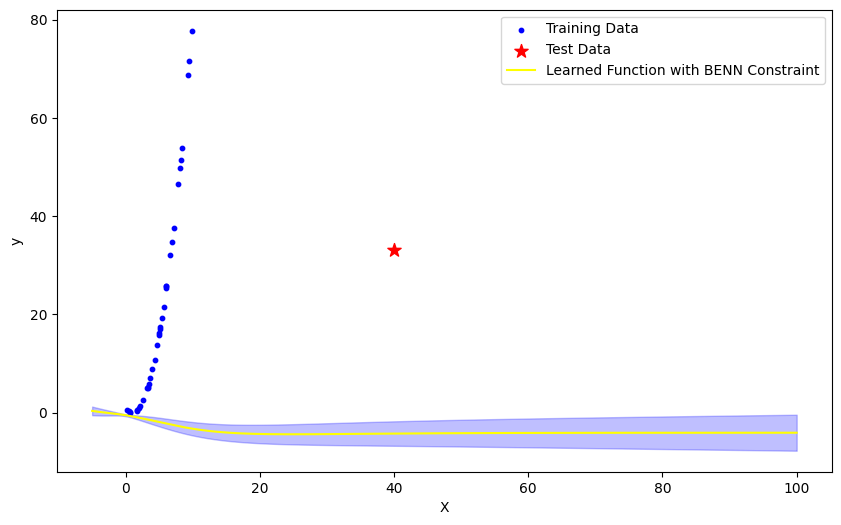

"\nloss_data_history = (loss_data_history - np.min(loss_data_history))/(np.max(loss_data_history) - np.min(loss_data_history))\nloss_constraint_1_history = (loss_constraint_1_history - np.min(loss_constraint_1_history))/(np.max(loss_constraint_1_history) - np.min(loss_constraint_1_history))\n# loss_constraint_2_history = (loss_constraint_2_history - min(loss_constraint_2_history))/(max(loss_constraint_2_history) - min(loss_constraint_2_history))\n# loss_constraint_3_history   = (loss_constraint_3_history - min(loss_constraint_3_history))/(max(loss_constraint_3_history) - min(loss_constraint_3_history))\nplt.figure(figsize=(10, 6))\nplt.plot(loss_data_history, color='blue', label='Data Loss')\nplt.plot(loss_constraint_1_history, color='green', label='Constraint 1 Loss')\n# plt.plot(loss_constraint_2_history, color='red', label='Constraint 2 Loss')\n# plt.plot(loss_constraint_3_history, color='yellow', label='Constraint 3 Loss')\nplt.xlabel('Iteration')\nplt.ylabel('Loss')\nplt.legend()\

In [ ]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
# size of scatter points = 10, and test points need to be stars not circles
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test, y_test, color='red', label='Test Data', marker='*', s=100)
# plt.scatter(60.0, 30.0, color='green', label='Range Constraint - Lower Bound', marker='*', s=100)
# plt.scatter(60.0, 60.0, color='green', label='Range Constraint - Upper Bound', marker='*', s=100)
# linspaced test data
x_plot = torch.linspace(-5, 100, 1000).reshape(-1,1)

# y_plot = best_model(x_plot.to(device)).cpu().detach().numpy()
# preds = [best_model(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
# preds = np.stack(preds)
# mean = preds.mean(axis=0)
# std = preds.std(axis=0)
# ci_upper = mean + (1 * std)
# ci_lower = mean - (1 * std)

# y_plot_benn = best_model_benn(x_plot.to(device)).cpu().detach().numpy()
preds_benn = [best_model(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
preds_benn = np.stack(preds_benn)
mean_benn = preds_benn.mean(axis=0)
std_benn = preds_benn.std(axis=0)
ci_upper_benn = mean_benn + (25*std_benn)
ci_lower_benn = mean_benn - (25*std_benn)

# Compute MSE loss on train, test set and constraint set
mae_loss = nn.L1Loss()
loss_training = []
loss_val_constraints = []
for i in range(100):
    loss_training.append(mae_loss(best_model(X_train.to(device)), y_train.to(device)))
    loss_val_constraints.append(mae_loss(best_model(X_test.to(device)).reshape(len(X_test),), y_test.to(device)))
print('Training loss: ', torch.stack(loss_training).mean())
print('Val constraint loss: ', torch.stack(loss_val_constraints).mean())

# extract x_plot values between 25 and 27
# x_plot_deriv = x_plot[(x_plot>=10) & (x_plot<=11)]
# # compute line with slope dy_test_3, and y-intercept at mean_benn of x_plot_deriv >= 25 and <= 25.50
# y_plot_deriv = dy_test_3*(x_plot_deriv)


# plt.plot(x_plot, mean, color='red', label='Learned Function')
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='orange', alpha=0.25)
plt.plot(x_plot, mean_benn, color='yellow', label='Learned Function with BENN Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='blue', alpha=0.25)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# Plot loss histories 
'''
loss_data_history = (loss_data_history - np.min(loss_data_history))/(np.max(loss_data_history) - np.min(loss_data_history))
loss_constraint_1_history = (loss_constraint_1_history - np.min(loss_constraint_1_history))/(np.max(loss_constraint_1_history) - np.min(loss_constraint_1_history))
# loss_constraint_2_history = (loss_constraint_2_history - min(loss_constraint_2_history))/(max(loss_constraint_2_history) - min(loss_constraint_2_history))
# loss_constraint_3_history   = (loss_constraint_3_history - min(loss_constraint_3_history))/(max(loss_constraint_3_history) - min(loss_constraint_3_history))
plt.figure(figsize=(10, 6))
plt.plot(loss_data_history, color='blue', label='Data Loss')
plt.plot(loss_constraint_1_history, color='green', label='Constraint 1 Loss')
# plt.plot(loss_constraint_2_history, color='red', label='Constraint 2 Loss')
# plt.plot(loss_constraint_3_history, color='yellow', label='Constraint 3 Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot eta history
plt.figure(figsize=(10, 6))
plt.plot(eta_history, color='blue', label='eta')
plt.xlabel('Iteration')
plt.ylabel('eta')
plt.legend()
plt.show()

'''

In [ ]:
from venv import create


torch.manual_seed(6)
x = torch.randn(1, 1, requires_grad=True)
y = torch.randn(1, 1, requires_grad=True)
# lets say for example that the derivative of z wrt x needs to be 2.0
# we have to create a loss function that enforces the derivative of z wrt x to be 2.0

def derivative_loss():
    z = x * y
    z.backward()
    z.grad_fn
    return (x.grad**2).requires_grad_()

optimizer = optim.SGD([x, y], lr=0.1)
for i in range(25):
    optimizer.zero_grad()
    loss = derivative_loss()
    loss.backward()
    optimizer.step()
    print('z: {:.4f}, x: {:.4f}, y: {:.4f}, x_grad: {:.4f}, loss: {:.4f}'.format(z.item(), x.item(), y.item(), x.grad.item(), loss.item()))

z: 1.8625, x: -1.7750, y: -0.8062, x_grad: -0.9937, loss: 0.9874
z: 1.8625, x: -1.6944, y: -0.6287, x_grad: -0.8062, loss: 0.6500
z: 1.8625, x: -1.6315, y: -0.4593, x_grad: -0.6287, loss: 0.3953
z: 1.8625, x: -1.5856, y: -0.2961, x_grad: -0.4593, loss: 0.2109
z: 1.8625, x: -1.5560, y: -0.1376, x_grad: -0.2961, loss: 0.0877
z: 1.8625, x: -1.5422, y: 0.0180, x_grad: -0.1376, loss: 0.0189
z: 1.8625, x: -1.5440, y: 0.1723, x_grad: 0.0180, loss: 0.0003
z: 1.8625, x: -1.5613, y: 0.3267, x_grad: 0.1723, loss: 0.0297
z: 1.8625, x: -1.5939, y: 0.4828, x_grad: 0.3267, loss: 0.1067
z: 1.8625, x: -1.6422, y: 0.6422, x_grad: 0.4828, loss: 0.2331
z: 1.8625, x: -1.7064, y: 0.8064, x_grad: 0.6422, loss: 0.4124
z: 1.8625, x: -1.7871, y: 0.9770, x_grad: 0.8064, loss: 0.6503
z: 1.8625, x: -1.8848, y: 1.1558, x_grad: 0.9770, loss: 0.9546
z: 1.8625, x: -2.0004, y: 1.3442, x_grad: 1.1558, loss: 1.3358
z: 1.8625, x: -2.1348, y: 1.5443, x_grad: 1.3442, loss: 1.8070
z: 1.8625, x: -2.2892, y: 1.7577, x_grad: 1.

The above example shows that in the toy case of z = x * y, we are unable to directly affect the derivative of z wrt x. This is because requires_grad_ does not seem to affect the derivative of z wrt x.

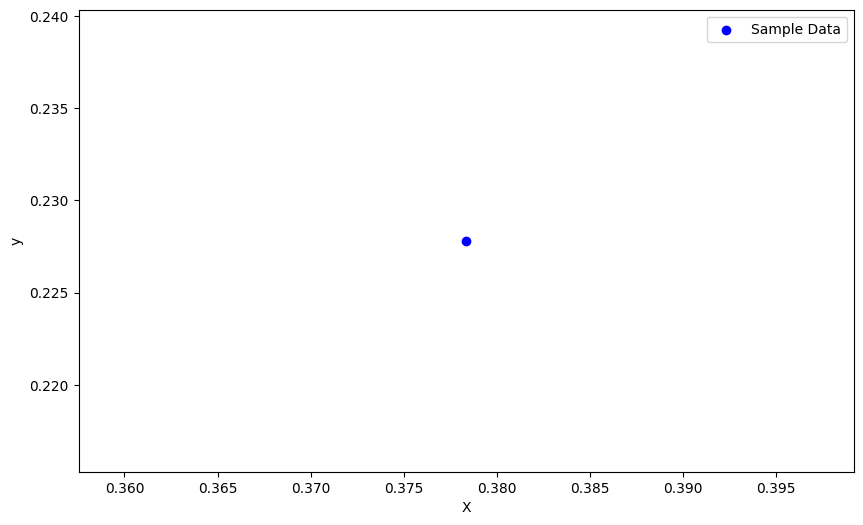

In [12]:
# 1-D linear regression with sample data

# sample function : y = 2x + 1
# sample data
x = torch.randn(1,1)
y = -2*x + 1 + 0.1*torch.randn(1,1)

# plot the sample data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Sample Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Epoch [1/50], Loss: 0.0086 Deriv_loss: 15.5847
Epoch [11/50], Loss: 0.0123 Deriv_loss: 0.1335
Epoch [21/50], Loss: 2.3728 Deriv_loss: 0.2111
Epoch [31/50], Loss: 0.0421 Deriv_loss: 0.0517
Epoch [41/50], Loss: 0.0098 Deriv_loss: 0.1630
Epoch [51/50], Loss: 2.2806 Deriv_loss: 0.1992
Epoch [61/50], Loss: 0.0416 Deriv_loss: 0.0509
Epoch [71/50], Loss: 0.0097 Deriv_loss: 0.1606
Epoch [81/50], Loss: 2.2451 Deriv_loss: 0.1961
Epoch [91/50], Loss: 0.0412 Deriv_loss: 0.0500
Epoch [101/50], Loss: 0.0095 Deriv_loss: 0.1582
Epoch [111/50], Loss: 2.2103 Deriv_loss: 0.1930
Epoch [121/50], Loss: 0.0407 Deriv_loss: 0.0492
Epoch [131/50], Loss: 0.0094 Deriv_loss: 0.1558
Epoch [141/50], Loss: 2.1761 Deriv_loss: 0.1899
Epoch [151/50], Loss: 0.0402 Deriv_loss: 0.0484
Epoch [161/50], Loss: 0.0093 Deriv_loss: 0.1535
Epoch [171/50], Loss: 2.1425 Deriv_loss: 0.1869
Epoch [181/50], Loss: 0.0397 Deriv_loss: 0.0476
Epoch [191/50], Loss: 0.0091 Deriv_loss: 0.1512
Epoch [201/50], Loss: 2.1094 Deriv_loss: 0.1840
Ep

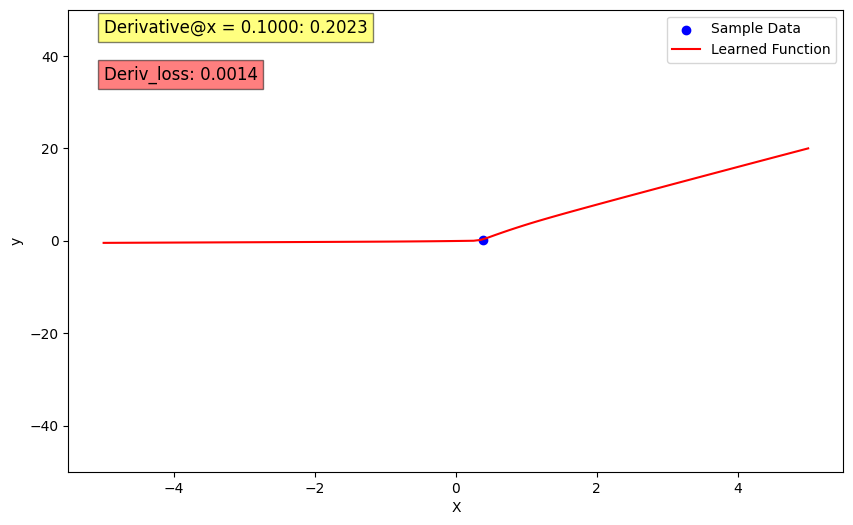

In [42]:
# linear model in torch
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear1 = nn.Linear(1, 2048)
        self.linear2 = nn.Linear(2048, 1)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        return self.leaky_relu(self.linear2(self.leaky_relu(self.linear1(x))))
    
# create model
model = LinearModel()
# create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
# create loss function
criterion = nn.MSELoss()
dy = torch.tensor(4.0).reshape(1,1)
dx = torch.tensor(0.1).reshape(1,1)
# train the model
for epoch in range(6000):
    optimizer.zero_grad()
    y_hat = model(x)
    # estimate the derivative of y_hat wrt x without using autograd
    dy_hat = (model(x + dx) - model(x - dx))/(2*dx)
    deriv_loss = criterion(dy_hat, dy)
    loss = criterion(y_hat, y)
    total_loss = loss + deriv_loss
    total_loss.backward()
    optimizer.step()
    if epoch%10==0:
        print('Epoch [{}/{}], Loss: {:.4f} Deriv_loss: {:.4f}'.format(epoch+1, 50, loss.item(), deriv_loss.item()))
    



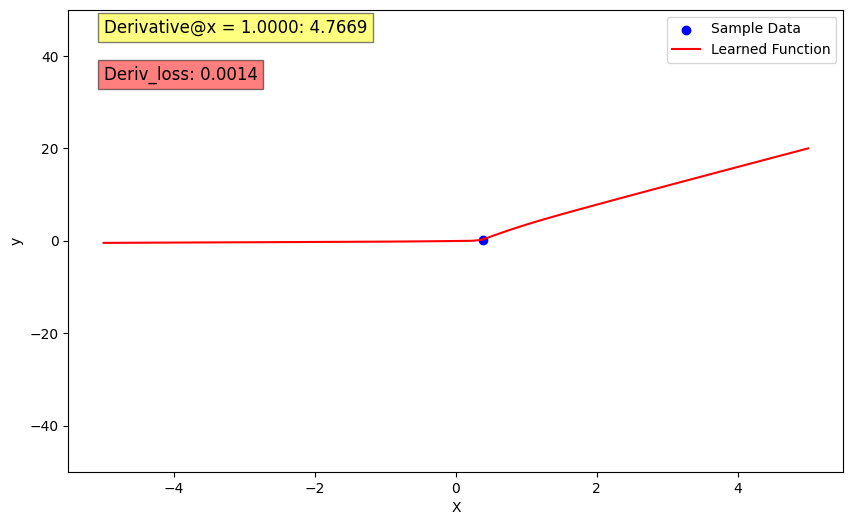

In [47]:
# plot the learned function on some test points 
x_test = torch.linspace(-5, 5, 100).reshape(-1,1)
y_test = model(x_test)
# plot the sample data - rescaled to -50, 50
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Sample Data')
plt.plot(x_test, y_test.detach().numpy(), color='red', label='Learned Function')
plt.ylim(-50, 50)  # Set the y-axis limits to -50 and 50
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
# print the derivative of the learned function 
# print the derivative of the learned function 
x_deriv = torch.tensor([1.0]).reshape(1,1)
dy_test = (model(x_deriv + dx) - model(x_deriv - dx))/(2*dx)
plt.text(-5, 45, 'Derivative@x = {:.4f}: {:.4f}'.format(x_deriv.item(), dy_test.item()), fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
# next plt.text the deriv_loss 
plt.text(-5, 35, 'Deriv_loss: {:.4f}'.format(deriv_loss.item()), fontsize=12, bbox=dict(facecolor='red', alpha=0.5)) 
plt.show()


Success!! I was able to enforce the derivative constraints by using finite differences to calculate the derivative of y_hat wrt x. This is a bit of a hack, but it works. I tried it when I have just 1 training point, but know the slope of the function at that point. I am not sure if this will work for more complex functions, but it is a start.

Now, I want to introduce more training points and see if I can enforce the derivative constraints for a 1D regression problem.

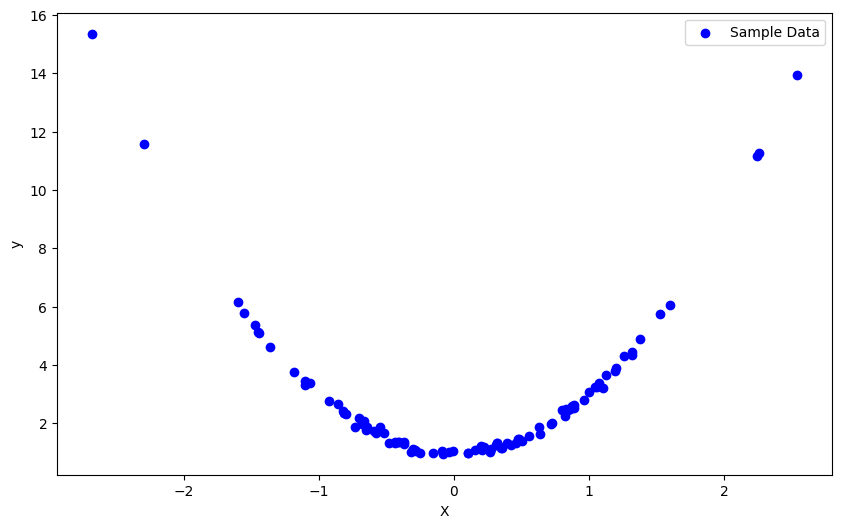

In [50]:
# generate some random data
x = torch.randn(100, 1)
# y is a non-linear function of x
y = 2*x**2 + 1 + 0.1*torch.randn(100, 1)
# plot the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Sample Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


Epoch [1/50], Loss: 14.3071 Deriv_loss 1: 15.7238 Deriv_loss 2:16.2883
Epoch [11/50], Loss: 5.9067 Deriv_loss 1: 21.4608 Deriv_loss 2:11.2804
Epoch [21/50], Loss: 5.1692 Deriv_loss 1: 19.6152 Deriv_loss 2:12.7527
Epoch [31/50], Loss: 4.8131 Deriv_loss 1: 18.8632 Deriv_loss 2:13.3723
Epoch [41/50], Loss: 4.2966 Deriv_loss 1: 18.5967 Deriv_loss 2:13.5985
Epoch [51/50], Loss: 3.3536 Deriv_loss 1: 20.0975 Deriv_loss 2:12.3691
Epoch [61/50], Loss: 2.8447 Deriv_loss 1: 18.3338 Deriv_loss 2:13.8250
Epoch [71/50], Loss: 2.1496 Deriv_loss 1: 17.9971 Deriv_loss 2:14.1203
Epoch [81/50], Loss: 1.6356 Deriv_loss 1: 17.4260 Deriv_loss 2:14.6350
Epoch [91/50], Loss: 8.2980 Deriv_loss 1: 14.2231 Deriv_loss 2:17.9025
Epoch [101/50], Loss: 2.9566 Deriv_loss 1: 20.6373 Deriv_loss 2:11.7637
Epoch [111/50], Loss: 8.3791 Deriv_loss 1: 12.0498 Deriv_loss 2:20.5093
Epoch [121/50], Loss: 2.7322 Deriv_loss 1: 29.2513 Deriv_loss 2:6.7130
Epoch [131/50], Loss: 2.8330 Deriv_loss 1: 19.8733 Deriv_loss 2:12.5330
Epo

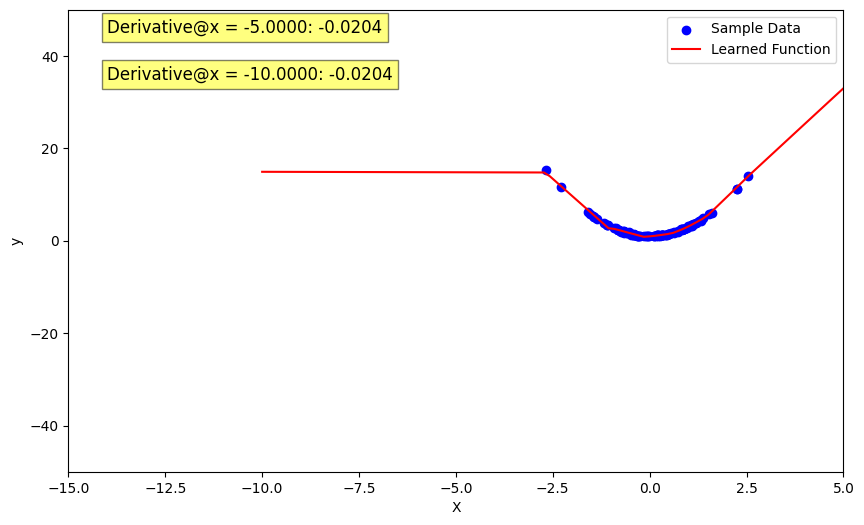

In [55]:
# PyTorch NN for non-linear regression w/ 4 layers 
class NonLinearModel(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super(NonLinearModel, self).__init__()
        self.nInput  = nInput
        self.nHidden = nHidden
        self.nOutput = nOutput
        self.linear1 = nn.Linear(self.nInput, self.nHidden)
        self.linear2 = nn.Linear(self.nHidden, self.nHidden)
        self.linear3 = nn.Linear(self.nHidden, self.nHidden)
        self.linear4 = nn.Linear(self.nHidden, self.nOutput)
        self.ReLU    = nn.ReLU()

    def forward(self, x):
        h1 = self.ReLU(self.linear1(x))
        h2 = self.ReLU(self.linear2(h1))
        h3 = self.ReLU(self.linear3(h2))
        output = self.linear4(h3)
        return(output)

nInput  = 1
nHidden = 36
nOutput = 1

# create model
model = NonLinearModel(nInput = nInput, nHidden = nHidden, nOutput = nOutput)
# create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# create loss function
criterion = nn.MSELoss()
dx = torch.tensor(0.1).reshape(1,1)
x_deriv_1 = torch.tensor(-5.0).reshape(1,1)
dy_1 = torch.tensor(+4.0).reshape(1,1)
x_deriv_2 = torch.tensor(-10.0).reshape(1,1)
dy_2 = torch.tensor(-4.0).reshape(1,1)
dy = torch.cat((dy_1, dy_2), dim=0)
# train the model
for epoch in range(5000):
    optimizer.zero_grad()
    y_hat = model(x)
    # estimate the derivative of y_hat wrt x without using autograd
    dy_hat_1 = (model(x_deriv_1 + dx) - model(x_deriv_1 - dx))/(2*dx)
    dy_hat_2 = (model(x_deriv_2 + dx) - model(x_deriv_2 - dx))/(2*dx)
    deriv_loss_1 = criterion(dy_hat_1, dy_1)
    deriv_loss_2 = criterion(dy_hat_2, dy_2)
    loss = criterion(y_hat, y)
    total_loss = loss + deriv_loss_1 + deriv_loss_2
    total_loss.backward()
    optimizer.step()
    if epoch%10==0:
        print('Epoch [{}/{}], Loss: {:.4f} Deriv_loss 1: {:.4f} Deriv_loss 2:{:.4f}'.format(epoch+1, 50, loss.item(), deriv_loss_1.item(), deriv_loss_2.item()))
    

# plot the learned function on some test points 
x_test = torch.linspace(-10, 5, 100).reshape(-1,1)
y_test = model(x_test)
# plot the sample data - rescaled to -50, 50
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Sample Data')
plt.plot(x_test, y_test.detach().numpy(), color='red', label='Learned Function')
plt.ylim(-50, 50)  # Set the y-axis limits to -50 and 50
plt.xlim(-15, 5)  # Set the x-axis limits to -15 and 5
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
# print the derivative of the learned function 
dy_test_1 = (model(x_deriv_1 + dx) - model(x_deriv_1 - dx))/(2*dx)
dy_test_2 = (model(x_deriv_2 + dx) - model(x_deriv_2 - dx))/(2*dx)
plt.text(-14, 45, 'Derivative@x = {:.4f}: {:.4f}'.format(x_deriv_1.item(), dy_test_1.item()), fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.text(-14, 35, 'Derivative@x = {:.4f}: {:.4f}'.format(x_deriv_2.item(), dy_test_2.item()), fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.show()


Another success for the 1D case. I was able to enforce the derivative constraints for a 1D regression problem. I am not sure if this will work for higher dimensions, but it is a start!!!
In the above case, I was able to show compliance with multiple derivative constraints and single derivative constraints too. 

The next experiment is for curvature constraints.

Epoch [1/50], Loss: 21.5550 Deriv_loss: 0.0002 Curvature_Loss: 1.0000
Epoch [11/50], Loss: 21.4337 Deriv_loss: 0.0000 Curvature_Loss: 1.0000
Epoch [21/50], Loss: 21.3153 Deriv_loss: 0.0000 Curvature_Loss: 1.0000
Epoch [31/50], Loss: 21.1980 Deriv_loss: 0.0000 Curvature_Loss: 1.0000
Epoch [41/50], Loss: 21.0721 Deriv_loss: 0.0001 Curvature_Loss: 1.0000
Epoch [51/50], Loss: 20.9571 Deriv_loss: 0.0003 Curvature_Loss: 1.0000
Epoch [61/50], Loss: 20.8428 Deriv_loss: 0.0005 Curvature_Loss: 1.0000
Epoch [71/50], Loss: 20.7290 Deriv_loss: 0.0008 Curvature_Loss: 1.0000
Epoch [81/50], Loss: 20.6157 Deriv_loss: 0.0012 Curvature_Loss: 1.0000
Epoch [91/50], Loss: 20.5025 Deriv_loss: 0.0017 Curvature_Loss: 1.0000
Epoch [101/50], Loss: 20.3956 Deriv_loss: 0.0022 Curvature_Loss: 1.0000
Epoch [111/50], Loss: 20.2839 Deriv_loss: 0.0029 Curvature_Loss: 1.0000
Epoch [121/50], Loss: 20.1712 Deriv_loss: 0.0037 Curvature_Loss: 1.0000
Epoch [131/50], Loss: 20.0581 Deriv_loss: 0.0045 Curvature_Loss: 1.0000
Epo

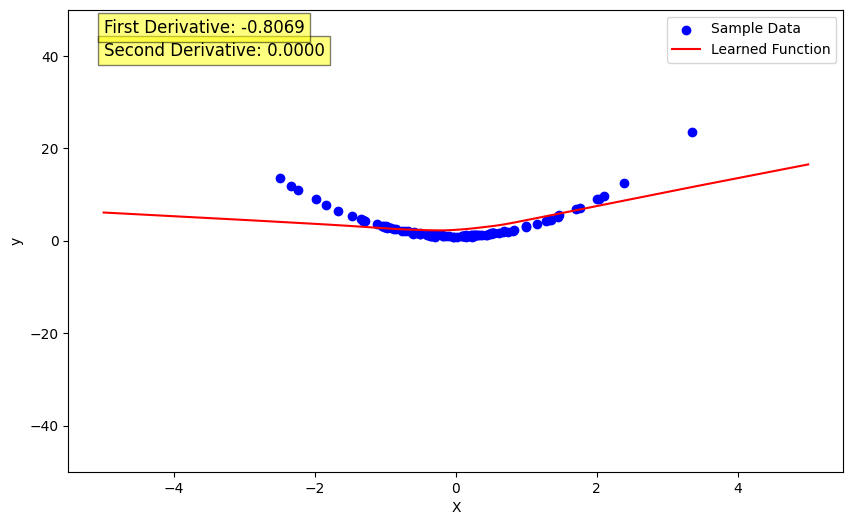

In [168]:
# PyTorch NN for non-linear regression w/ 4 layers 
class NonLinearModel(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super(NonLinearModel, self).__init__()
        self.nInput  = nInput
        self.nHidden = nHidden
        self.nOutput = nOutput
        self.linear1 = nn.Linear(self.nInput, self.nHidden)
        self.linear2 = nn.Linear(self.nHidden, self.nHidden)
        self.linear3 = nn.Linear(self.nHidden, self.nHidden)
        self.linear4 = nn.Linear(self.nHidden, self.nOutput)
        self.ReLU    = nn.ReLU()

    def forward(self, x):
        h1 = self.ReLU(self.linear1(x))
        h2 = self.ReLU(self.linear2(h1))
        h3 = self.ReLU(self.linear3(h2))
        output = self.linear4(h3)
        return(output)

nInput  = 1
nHidden = 64
nOutput = 1

# create model
model = NonLinearModel(nInput = nInput, nHidden = nHidden, nOutput = nOutput)
# create optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
dy = torch.tensor(-0.0).reshape(1,1)
dy2 = torch.tensor(-1.0).reshape(1,1)
dx = torch.tensor(0.1).reshape(1,1)
x_deriv = torch.tensor(-4.0).reshape(1,1)
# train the model
for epoch in range(2000):
    optimizer.zero_grad()
    y_hat = model(x)
    # estimate the derivative of y_hat wrt x without using autograd
    dy_hat = (model(x_deriv + dx) - model(x_deriv - dx))/(2*dx)
    # estimate the second derivative of y_hat wrt x without using autograd
    dy2_hat = (model(x_deriv + dx) - 2*model(x_deriv) + model(x_deriv - dx))/(dx**2)
    deriv_loss = criterion(dy_hat, dy)
    curvature_loss = criterion(dy2_hat, dy2)
    loss = criterion(y_hat, y)
    total_loss = loss + deriv_loss + curvature_loss
    total_loss.backward()
    optimizer.step()
    if epoch%10==0:
        print('Epoch [{}/{}], Loss: {:.4f} Deriv_loss: {:.4f} Curvature_Loss: {:.4f}'.format(epoch+1, 50, loss.item(), deriv_loss.item(), curvature_loss.item()))
    

# plot the learned function on some test points 
x_test = torch.linspace(-5, 5, 100).reshape(-1,1)
y_test = model(x_test)
# plot the sample data - rescaled to -50, 50
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Sample Data')
plt.plot(x_test, y_test.detach().numpy(), color='red', label='Learned Function')
plt.ylim(-50, 50)  # Set the y-axis limits to -50 and 50
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
# print the derivative of the learned function 
dy_test = (model(x_deriv + dx) - model(x_deriv - dx))/(2*dx)
dy2_test = (model(x_deriv + dx) - 2*model(x_deriv) + model(x_deriv - dx))/(dx**2)
print('Derivative of the learned function: ', dy_test)
# write the second derivative of the learned function on the plot itself inside a box on the top left corner
plt.text(-5, 40, 'Second Derivative: {:.4f}'.format(dy2_test.item()), fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.text(-5, 45, 'First Derivative: {:.4f}'.format(dy_test.item()), fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.show()
